In [7]:
# Imports & setup
import os, re, math, random
from pathlib import Path
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.io as tvio  # fast image decode (RGB)
from PIL import Image

# speed & determinism
def set_seed(s=123):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)

torch.backends.cudnn.benchmark = True  # fixed 256x256 → faster
set_seed(42)

def psnr(x: torch.Tensor, y: torch.Tensor, eps=1e-8) -> float:
    mse = F.mse_loss(x, y).item()
    if mse <= eps: return 99.0
    return 10.0 * math.log10(1.0 / mse)

device = torch.device(
    "mps" if torch.backends.mps.is_available() else
    ("cuda" if torch.cuda.is_available() else "cpu")
)


In [8]:
class NoisyCleanDataset(Dataset):
    def __init__(self, root: str, size: Optional[int]=None):
        self.root = Path(root)
        self.clean_dir = self.root / "clean"
        self.add_dir = self.root / "additive"
        self.mul_dir  = self.root / "multiplicative"
        assert self.clean_dir.is_dir() and self.add_dir.is_dir() and self.mul_dir.is_dir(), "Folders missing"

        self.clean_files = sorted(self.clean_dir.glob("img_*.png"))
        if size is not None:
            self.clean_files = self.clean_files[:size]

        self.add_map: Dict[str, List[Path]] = {}
        self.mul_map: Dict[str, List[Path]] = {}

        for cf in self.clean_files:
            m = re.match(r"img_(\d+)\.png", cf.name)
            if not m: 
                continue
            cid = m.group(1)
            adds = sorted(self.add_dir.glob(f"img_{cid}_add_*.png"))
            if adds: self.add_map[cid] = adds
            muls = sorted(self.mul_dir.glob(f"img_{cid}_mul_*.png"))
            if not muls:
                muls = sorted(self.mul_dir.glob(f"image_{cid}_mul_*.png"))
            if muls: self.mul_map[cid] = muls

        self.ids = [re.match(r"img_(\d+)\.png", p.name).group(1)
                    for p in self.clean_files
                    if (re.match(r"img_(\d+)\.png", p.name)
                        and (self.add_map.get(re.match(r"img_(\d+)\.png", p.name).group(1))
                             or self.mul_map.get(re.match(r"img_(\d+)\.png", p.name).group(1))))]

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def _read_rgb01(path: Path) -> torch.Tensor:
        t = tvio.read_image(str(path))
        return t.float().div_(255.0)

    def __getitem__(self, idx):
        cid = self.ids[idx]
        clean_path = self.clean_dir / f"img_{cid}.png"

        choices = []
        if cid in self.add_map: choices.append("add")
        if cid in self.mul_map: choices.append("mul")
        noise_type = random.choice(choices)

        if noise_type == "add":
            noisy_path = random.choice(self.add_map[cid]); noise_label = 0
        else:
            noisy_path = random.choice(self.mul_map[cid]); noise_label = 1

        clean_t = self._read_rgb01(clean_path)
        noisy_t = self._read_rgb01(noisy_path)
        return noisy_t, clean_t, noise_label


In [14]:
# Branch A: 8 filters per color channel (total 24), kernel 11x11, linear
class BranchA_Filters(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=11, padding=5, bias=True, groups=3)
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='linear')
        nn.init.zeros_(self.conv.bias)

    def forward(self, x):
        return self.conv(x)  # [B,24,H,W]

# ResNet block (32 channels)
class ResBlock(nn.Module):
    def __init__(self, in_ch, use_bn=True, p_drop=0.0):
        super().__init__()
        self.use_proj = (in_ch != 32)
        self.conv1 = nn.Conv2d(in_ch, 32, 3, padding=1, bias=not use_bn)
        self.bn1   = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, bias=not use_bn)
        self.bn2   = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.relu  = nn.ReLU(inplace=True)
        self.drop  = nn.Dropout2d(p_drop) if p_drop > 0 else nn.Identity()
        self.proj  = nn.Conv2d(in_ch, 32, 1) if self.use_proj else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = self.relu(out); out = self.drop(out)
        out = self.conv2(out); out = self.bn2(out)
        if self.use_proj: identity = self.proj(identity)
        out = self.relu(out + identity)
        return out

# Branch B: 3×ResBlock(32ch) → 1×1 conv → 8 ch → softmax per pixel
class BranchB_Weights(nn.Module):
    def __init__(self, use_bn=True, p_drop=0.0):
        super().__init__()
        self.block1 = ResBlock(3, use_bn=use_bn, p_drop=p_drop)
        self.block2 = ResBlock(32, use_bn=use_bn, p_drop=p_drop)
        self.block3 = ResBlock(32, use_bn=use_bn, p_drop=p_drop)
        self.to8    = nn.Conv2d(32, 8, kernel_size=1)

    def forward(self, x):
        out = self.block1(x); out = self.block2(out); out = self.block3(out)
        logits = self.to8(out)                 # [B,8,H,W]
        weights = F.softmax(logits, dim=1)     # channel-wise softmax
        return weights

# Full model
class EdgePreservingDenoiser(nn.Module):
    def __init__(self, use_bn=True, p_drop=0.0):
        super().__init__()
        self.branchA = BranchA_Filters()
        self.branchB = BranchB_Weights(use_bn=use_bn, p_drop=p_drop)

    def forward(self, x):
        A = self.branchA(x)    # [B,24,H,W]
        W = self.branchB(x)    # [B,8,H,W]

        A_R = A[:, 0:8,  :, :]
        A_G = A[:, 8:16, :, :]
        A_B = A[:,16:24, :, :]

        R = (A_R * W).sum(1, keepdim=True)
        G = (A_G * W).sum(1, keepdim=True)
        B = (A_B * W).sum(1, keepdim=True)
        return torch.cat([R,G,B], dim=1)  # [B,3,H,W]


In [17]:
print("Device:", device)

# small dataset first to avoid long startup
train_ds = NoisyCleanDataset("dataset", size=8192)   # grow later
train_dl = DataLoader(
    train_ds, batch_size=4, shuffle=True,
    num_workers=8, pin_memory=True,
    persistent_workers=True, prefetch_factor=4, drop_last=True
)

model = EdgePreservingDenoiser(use_bn=True, p_drop=0.0).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


Device: mps


In [18]:
def check_sample(x):
    if isinstance(x, torch.Tensor):
        return True
    # allow numpy arrays but convertable to tensor
    try:
        _ = torch.as_tensor(x)
        return True
    except Exception:
        return False

bad_indices = []
for i in range(min(32, len(train_ds) if 'train_ds' in globals() else len(ds))):
    try:
        noisy_i, clean_i, _ = (train_ds[i] if 'train_ds' in globals() else ds[i])
        assert check_sample(noisy_i), "noisy sample not tensor/convertible"
        assert check_sample(clean_i), "clean sample not tensor/convertible"
    except Exception as e:
        bad_indices.append((i, repr(e)))

if bad_indices:
    print("⚠️ Dataset errors at indices:", bad_indices[:5], "…")
    raise RuntimeError("Fix dataset item(s) above (e.g., path missing, shape mismatch, dtype issue).")

# --- 2) Rebuild DataLoader WITHOUT multiprocessing (Jupyter/macOS safe) ---
def make_loader(dataset, device, batch_size=4):
    use_cuda = (device.type == "cuda")
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=True,
        num_workers=0,              # <- critical fix in notebooks/macOS
        pin_memory=use_cuda,        # only helpful on CUDA
        persistent_workers=False,   # only valid with num_workers>0
        drop_last=True
    )

# Prefer train_ds if you have separate splits; else use ds
active_ds = train_ds if 'train_ds' in globals() else ds
train_dl = make_loader(active_ds, device, batch_size=4)

# --- 3) One sanity training step ---
model.to(device).train()

noisy, clean, _ = next(iter(train_dl))
noisy = noisy.to(device, non_blocking=True)
clean = clean.to(device, non_blocking=True)

pred = model(noisy)
loss = loss_fn(pred, clean)

opt.zero_grad(set_to_none=True)
loss.backward()
opt.step()

with torch.no_grad():
    # simple PSNR over batch
    def _psnr(a, b, eps=1e-8):
        mse = torch.mean((a - b) ** 2).clamp_min(eps)
        return 10.0 * torch.log10(1.0 / mse)  # assumes inputs in [0,1]; adjust if needed
    bpsnr = _psnr(pred, clean).item()

if device.type == "mps":
    torch.mps.synchronize()

print(f"Sanity OK. Loss: {float(loss):.4f} | PSNR: {bpsnr:.2f} dB")

Sanity OK. Loss: 0.1842 | PSNR: 7.35 dB


In [19]:
# pip install tqdm
from tqdm import tqdm
import torch

def train_epochs(
    model, dl, opt, loss_fn, device,
    epochs=2, steps_per_epoch=None, save_path="edge_denoiser.pth"
):
    print("Training...")
    model.train()
    gstep = 0

    # In case your loader doesn't have a fixed length (e.g., IterableDataset)
    dl_len = len(dl) if hasattr(dl, "__len__") else None

    for ep in range(epochs):
        running_loss, running_psnr = 0.0, 0.0

        # How many steps this epoch?
        planned_steps = steps_per_epoch or dl_len
        if planned_steps is None:
            # fallback: show unknown total
            planned_steps = None

        pbar = tqdm(
            enumerate(dl, start=0),
            total=planned_steps,
            desc=f"Epoch {ep+1}/{epochs}",
            leave=True,
            dynamic_ncols=True
        )

        for i, (noisy, clean, _) in pbar:
            # Respect steps_per_epoch if set
            if steps_per_epoch is not None and (i >= steps_per_epoch):
                break

            noisy = noisy.to(device, non_blocking=True)
            clean = clean.to(device, non_blocking=True)

            pred = model(noisy)
            loss = loss_fn(pred, clean)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            with torch.no_grad():
                # average PSNR over the batch
                batch_psnr = sum(psnr(pred[b], clean[b]) for b in range(pred.size(0))) / pred.size(0)

            gstep += 1
            running_loss += loss.item()
            running_psnr += float(batch_psnr)

            # Nice, compact live stats on the bar
            cur_loss = loss.item()
            avg_loss = running_loss / (i + 1)
            avg_psnr = running_psnr / (i + 1)
            lr = opt.param_groups[0].get("lr", None)

            postfix = {
                "it": f"{i+1}/{planned_steps if planned_steps else '?'}",
                "loss": f"{cur_loss:.4f}",
                "avg": f"{avg_loss:.4f}",
                "psnr": f"{float(batch_psnr):.2f} dB",
                "avg_psnr": f"{avg_psnr:.2f} dB",
                "gstep": gstep,
            }
            if lr is not None:
                postfix["lr"] = f"{lr:.2e}"
            pbar.set_postfix(postfix)

        # End-of-epoch summary
        steps_done = (i + 1) if steps_per_epoch is None else min(i + 1, steps_per_epoch)
        print(f"[Epoch {ep+1}] avg loss {running_loss/max(1,steps_done):.4f} | "
              f"avg PSNR {running_psnr/max(1,steps_done):.2f} dB")
        torch.save(model.state_dict(), save_path)
        print(f"Saved → {save_path}")


train_epochs(model, train_dl, opt, loss_fn, device,
             epochs=10, steps_per_epoch=2048, save_path="edge_denoiser.pth")


Training...


Epoch 1/10: 100%|██████████| 2048/2048 [11:13<00:00,  3.04it/s, it=2048/2048, loss=0.0025, avg=0.0046, psnr=26.73 dB, avg_psnr=24.93 dB, gstep=2048, lr=1.00e-03]


[Epoch 1] avg loss 0.0046 | avg PSNR 24.93 dB
Saved → edge_denoiser.pth


Epoch 2/10: 100%|██████████| 2048/2048 [09:53<00:00,  3.45it/s, it=2048/2048, loss=0.0020, avg=0.0027, psnr=27.10 dB, avg_psnr=27.50 dB, gstep=4096, lr=1.00e-03]


[Epoch 2] avg loss 0.0027 | avg PSNR 27.50 dB
Saved → edge_denoiser.pth


Epoch 3/10: 100%|██████████| 2048/2048 [09:47<00:00,  3.49it/s, it=2048/2048, loss=0.0016, avg=0.0022, psnr=28.39 dB, avg_psnr=28.40 dB, gstep=6144, lr=1.00e-03]


[Epoch 3] avg loss 0.0022 | avg PSNR 28.40 dB
Saved → edge_denoiser.pth


Epoch 4/10: 100%|██████████| 2048/2048 [10:04<00:00,  3.39it/s, it=2048/2048, loss=0.0008, avg=0.0022, psnr=30.87 dB, avg_psnr=28.73 dB, gstep=8192, lr=1.00e-03]


[Epoch 4] avg loss 0.0022 | avg PSNR 28.73 dB
Saved → edge_denoiser.pth


Epoch 5/10: 100%|██████████| 2048/2048 [10:48<00:00,  3.16it/s, it=2048/2048, loss=0.0014, avg=0.0020, psnr=29.66 dB, avg_psnr=29.11 dB, gstep=10240, lr=1.00e-03]


[Epoch 5] avg loss 0.0020 | avg PSNR 29.11 dB
Saved → edge_denoiser.pth


Epoch 6/10: 100%|██████████| 2048/2048 [10:18<00:00,  3.31it/s, it=2048/2048, loss=0.0013, avg=0.0019, psnr=29.81 dB, avg_psnr=29.33 dB, gstep=12288, lr=1.00e-03]


[Epoch 6] avg loss 0.0019 | avg PSNR 29.33 dB
Saved → edge_denoiser.pth


Epoch 7/10: 100%|██████████| 2048/2048 [14:33<00:00,  2.34it/s, it=2048/2048, loss=0.0009, avg=0.0018, psnr=31.12 dB, avg_psnr=29.44 dB, gstep=14336, lr=1.00e-03]


[Epoch 7] avg loss 0.0018 | avg PSNR 29.44 dB
Saved → edge_denoiser.pth


Epoch 8/10: 100%|██████████| 2048/2048 [12:21<00:00,  2.76it/s, it=2048/2048, loss=0.0011, avg=0.0019, psnr=30.12 dB, avg_psnr=29.56 dB, gstep=16384, lr=1.00e-03]


[Epoch 8] avg loss 0.0019 | avg PSNR 29.56 dB
Saved → edge_denoiser.pth


Epoch 9/10: 100%|██████████| 2048/2048 [12:34<00:00,  2.71it/s, it=2048/2048, loss=0.0023, avg=0.0018, psnr=27.39 dB, avg_psnr=29.59 dB, gstep=18432, lr=1.00e-03]


[Epoch 9] avg loss 0.0018 | avg PSNR 29.59 dB
Saved → edge_denoiser.pth


Epoch 10/10: 100%|██████████| 2048/2048 [13:08<00:00,  2.60it/s, it=2048/2048, loss=0.0011, avg=0.0020, psnr=29.66 dB, avg_psnr=29.72 dB, gstep=20480, lr=1.00e-03]

[Epoch 10] avg loss 0.0020 | avg PSNR 29.72 dB
Saved → edge_denoiser.pth


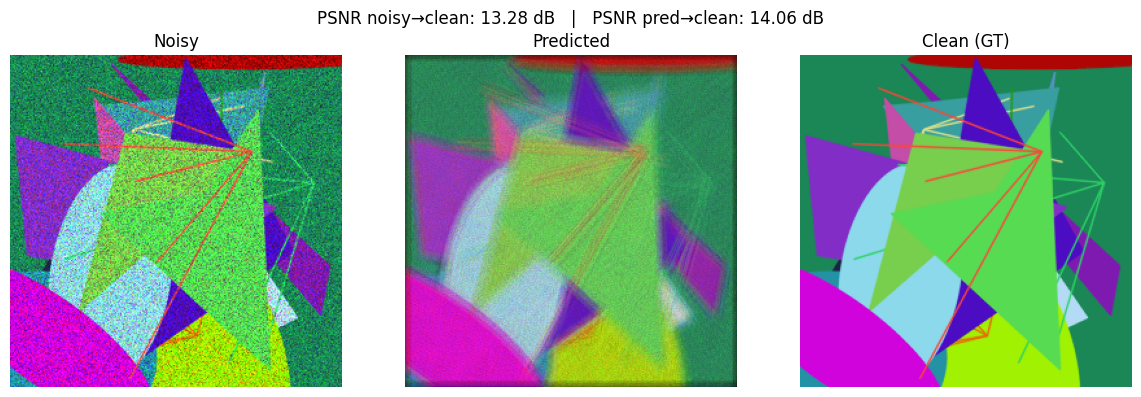

Saved images + metrics to: /Users/stefansrjakovferi/predmeti/third-semester/NaprednaObdelavaSlik/Vaja1-OdstranjevanjeSuma/inference_outputs


In [ ]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

model.eval()

# >>> set your paths here <<<
blurry_path = "/Users/stefansrjakovferi/predmeti/third-semester/NaprednaObdelavaSlik/Vaja1-OdstranjevanjeSuma/blurry_image.png"
clean_path  = "/Users/stefansrjakovferi/predmeti/third-semester/NaprednaObdelavaSlik/Vaja1-OdstranjevanjeSuma/clean_image.png"   # ground-truth clean image

noisy, clean = _match_size(noisy, clean)

# -------- inference --------
with torch.no_grad():
    pred = model(noisy)

if device.type == "mps":
    torch.mps.synchronize()

# -------- metrics --------
psnr_noisy  = _psnr(noisy.clamp(0,1), clean.clamp(0,1)).item()
psnr_pred   = _psnr(pred.clamp(0,1),  clean.clamp(0,1)).item()

# -------- visualize --------
to_show = [("Noisy", noisy[0]), ("Predicted", pred[0]), ("Clean (GT)", clean[0])]
cols = len(to_show)
plt.figure(figsize=(4 * cols, 4))
for i, (title, img_t) in enumerate(to_show, 1):
    plt.subplot(1, cols, i)
    plt.imshow(_to_image_numpy(img_t, auto_rescale=True))
    plt.title(title)
    plt.axis("off")
plt.suptitle(f"PSNR noisy→clean: {psnr_noisy:.2f} dB   |   PSNR pred→clean: {psnr_pred:.2f} dB", y=0.98)
plt.tight_layout()
plt.show()

# -------- save results --------
from PIL import Image
out_dir = Path("inference_outputs"); out_dir.mkdir(parents=True, exist_ok=True)
for title, img_t in to_show:
    Image.fromarray(_to_image_numpy(img_t, auto_rescale=True)).save(out_dir / f"{title.replace(' ', '_').lower()}.png")

with open(out_dir / "metrics.txt", "w") as f:
    f.write(f"PSNR noisy->clean: {psnr_noisy:.4f} dB\n")
    f.write(f"PSNR pred->clean:  {psnr_pred:.4f} dB\n")

print(f"Saved images + metrics to: {out_dir.resolve()}")

In [35]:
def _to_image_numpy(t: torch.Tensor, auto_rescale=True):
    # Accepts CHW or HWC (with 1 or 3 channels) and returns uint8 HWC
    if t.ndim == 3 and t.shape[0] in (1, 3):         # CHW -> HWC
        t = t.detach().cpu().float()
        t = t if t.shape[0] != 1 else t.repeat(3, 1, 1)
        x = t.permute(1, 2, 0)
    elif t.ndim == 2:                                 # HxW -> HxWx3
        x = t.detach().cpu().float()[..., None].repeat(1, 1, 3)
    elif t.ndim == 3 and t.shape[-1] in (1, 3):       # already HWC
        x = t.detach().cpu().float()
        if x.shape[-1] == 1:
            x = x.repeat(1, 1, 3)
    else:
        raise ValueError(f"Unexpected tensor shape for image: {tuple(t.shape)}")

    if auto_rescale:
        x_min, x_max = float(x.min()), float(x.max())
        if 0.0 <= x_min and x_max <= 1.0:
            pass
        elif -1.0 <= x_min and x_max <= 1.0:
            x = (x + 1.0) / 2.0
        else:
            if x_max > x_min:
                x = (x - x_min) / (x_max - x_min)
            else:
                x = x * 0.0
    else:
        x = x.clamp(0, 1)

    return (x * 255.0).round().clamp(0, 255).byte().numpy()

def _load_rgb_image_as_chw(path: str):
    from PIL import Image
    img = Image.open(path).convert("RGB")
    arr = np.array(img) / 255.0           # HWC in [0,1]
    t = torch.from_numpy(arr).permute(2, 0, 1).float()   # CHW
    return t

def _psnr(x: torch.Tensor, y: torch.Tensor, eps=1e-8):
    # x,y: CHW or NCHW in [0,1]; returns PSNR (dB)
    if x.ndim == 4: x = x[0]
    if y.ndim == 4: y = y[0]
    mse = torch.mean((x - y) ** 2)
    return 20.0 * torch.log10(1.0 / torch.sqrt(mse + eps))

def _match_size(a, b):
    _, _, ha, wa = a.shape
    _, _, hb, wb = b.shape
    h, w = min(ha, hb), min(wa, wb)
    def ccrop(t):
        _, _, H, W = t.shape
        top = (H - h) // 2
        left = (W - w) // 2
        return t[:, :, top:top+h, left:left+w]
    return ccrop(a), ccrop(b)